In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
# from sklearn.compose import ColumnTransformer, make_column_transformer
# from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
# from sklearn.impute import SimpleImputer
# from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    cross_val_predict,
    train_test_split,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
%pip install xgboost
from xgboost import XGBRegressor
import xgboost as xgb
%pip install shap
import shap
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
## Loading the data
data = pd.read_csv("data/result.csv")
## DC,Washington,601723,1150000,20.3,18,20.5,25.4,35.2,51

In [3]:
## Checking if data is valid
print(data.head())
data.shape

  State   CityName  Population2010  cityfips  BingeDrinking  SmokingRate  \
0    GA     Albany           77434   1301052           10.9         23.7   
1    TX   Amarillo          190695   4803000           16.5         18.5   
2    AK  Anchorage          291826    203000           20.2         18.3   
3    GA    Atlanta          420003   1304000           14.1         16.6   
4    GA    Augusta          195844   1304204           12.5         21.8   

   NoPhysicalActivity  ObesityRate  SleepDeprivation  GeoCode  Cancer  \
0                33.1         40.4              46.9      525      76   
1                27.9         32.0              32.9      634      67   
2                19.2         27.7              33.4      743      62   
3                22.4         31.6              40.4      524      72   
4                28.1         36.0              44.1      520      69   

   Cardiovascular  Depression  Diabetes  Diarrhea  Obesity  Rehab  Stroke  \
0              71          

(80, 19)

In [18]:
data.describe()

,Population2010,cityfips,BingeDrinking,SmokingRate,NoPhysicalActivity,ObesityRate,SleepDeprivation,GeoCode,Cancer,Cardiovascular,Depression,Diabetes,Diarrhea,Obesity,Rehab,Stroke,Vaccine,Cluster
count,8.000000e+01,8.000000e+01,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,5.591782e+05,3.036162e+06,15.871250,21.106250,26.487500,33.058750,37.502500,632.237500,72.112500,43.037500,61.312500,70.825000,68.575000,46.375000,61.150000,59.512500,61.250000,1.325000
std,1.047132e+06,1.530581e+06,2.752637,3.883993,4.874589,5.125358,4.857487,102.731461,7.008121,12.274749,6.770363,7.050945,8.447567,11.755284,13.262777,7.857905,9.200303,0.868215
min,6.678800e+04,1.500300e+04,9.600000,11.200000,14.600000,19.700000,28.100000,501.000000,41.000000,21.000000,33.000000,47.000000,34.000000,24.000000,29.000000,36.000000,38.000000,0.000000
25%,1.402168e+05,1.832502e+06,14.250000,18.125000,24.475000,30.300000,34.000000,540.250000,67.750000,36.000000,57.000000,66.000000,64.000000,39.000000,52.750000,54.000000,55.750000,0.000000
50%,2.346500e+05,3.093600e+06,15.700000,21.900000,27.600000,33.450000,37.350000,618.500000,72.000000,40.000000,61.000000,71.000000,68.000000,45.000000,62.000000,60.000000,60.500000,2.000000
75%,5.980422e+05,4.324082e+06,17.550000,23.925000,29.050000,36.025000,40.250000,716.500000,77.000000,47.000000,67.000000,76.000000,73.000000,53.250000,68.500000,64.250000,66.000000,2.000000
max,8.175133e+06,5.553000e+06,22.700000,29.800000,37.600000,47.200000,50.800000,881.000000,85.000000,86.000000,77.000000,92.000000,99.000000,81.000000,98.000000,83.000000,100.000000,2.000000


## Data Preparation

Since we want to predict cardiovascular search trends using health behaviors, they are loaded as target and features respectively.

In [4]:
features = ['BingeDrinking', 'SmokingRate', 'NoPhysicalActivity', 'ObesityRate', 'SleepDeprivation']
target = 'Cardiovascular'

X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Effectiveness of using county-level health behaviors to predict cardiovascular related search trends

Using RMSE score during 5-fold cross validation to assess the four model's effectiveness.

Decision Tree:
  RMSE: Mean = 14.6019, Std = 3.0838

kNN:
  RMSE: Mean = 12.8598, Std = 3.4223

Random Forest:
  RMSE: Mean = 12.4677, Std = 3.8316

XGBoost:
  RMSE: Mean = 12.2593, Std = 4.3964



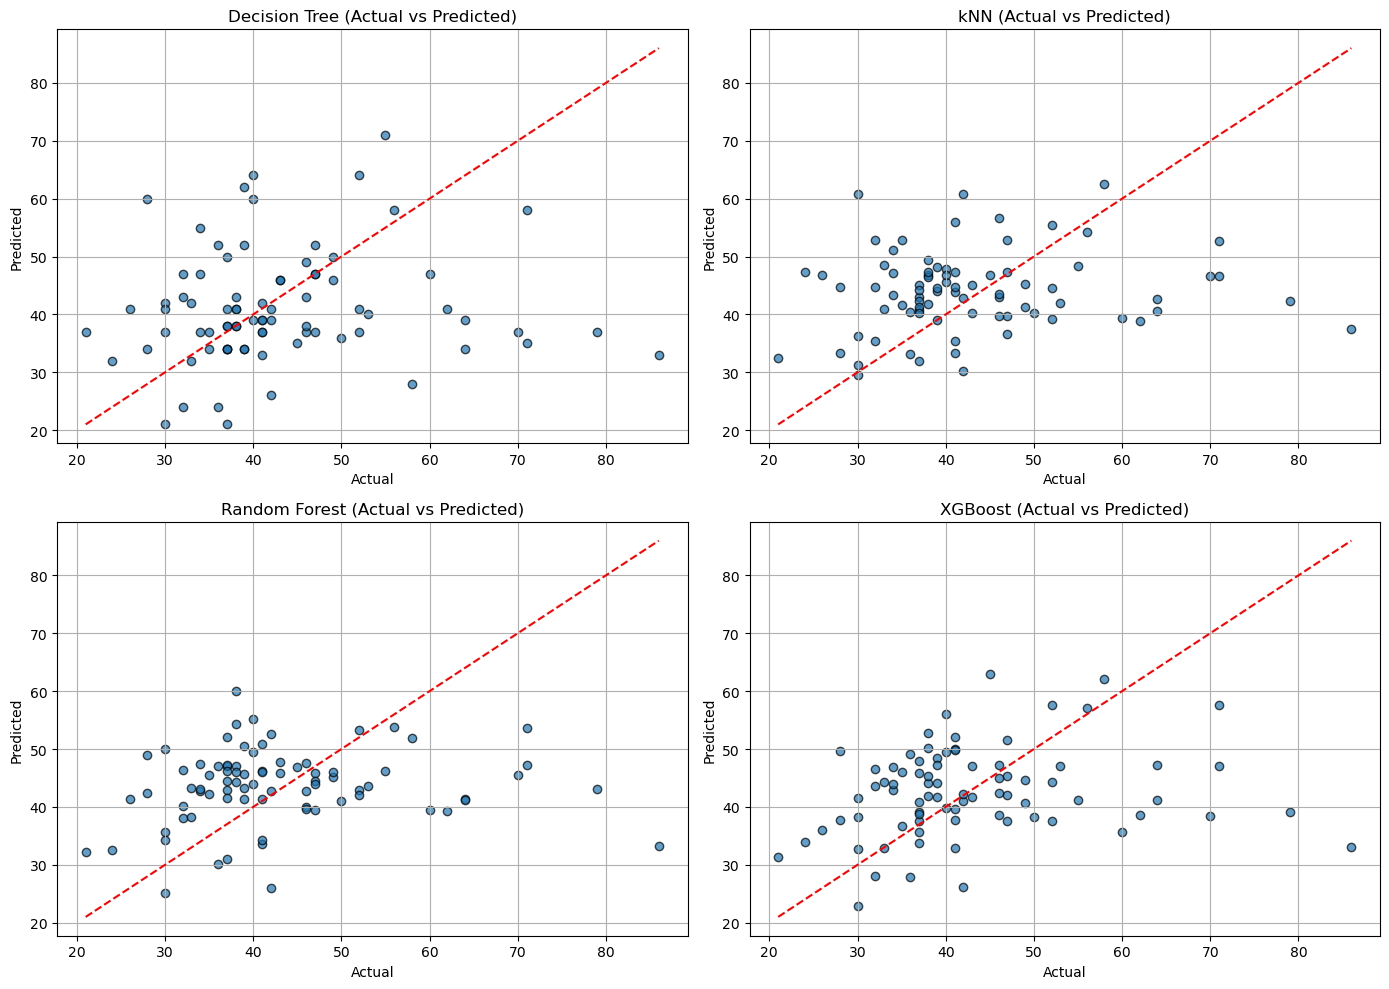

Mean Cardiovascular Search Score = 43.0375



In [5]:
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "kNN": KNeighborsRegressor(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0)
}

# Train and evaluate
cv = KFold(n_splits=5, shuffle=True, random_state=42)

plt.figure(figsize=(14, 10))
# Evaluate models
for i, (name, model) in enumerate(models.items(), 1):
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    rmse_scores = -cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    
    print(f"{name}:")
    print(f"  RMSE: Mean = {rmse_scores.mean():.4f}, Std = {rmse_scores.std():.4f}\n")

    y_pred = cross_val_predict(model, X, y, cv = cv)
    plt.subplot(2, 2, i)
    plt.scatter(y, y_pred, alpha=0.7, edgecolors='k')
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # reference line
    plt.title(f'{name} (Actual vs Predicted)')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Mean Cardiovascular Search Score = {y.mean()}\n")

#### Result Analysis

The result of the 4 models are mostly similar, where decision tree has a RMSE 14, while kNN, Random Forest, and XGBoost are all around 12. XGBoost is the best performing model with an RMSE of 12.2593. This implies that the average distance between predicted values and actual values is 12.2593. This is not a great result since the Percentage Error is around 27%, and a good model should have less than 10% error. However, we believe this model would do much better given a larger dataset, as there are only 80 observations in our data.

#### Health behaviors with the greatest impact on cardiovascular related search trends

The following are code used to conduct shap analysis on our best performing model XGBoost.

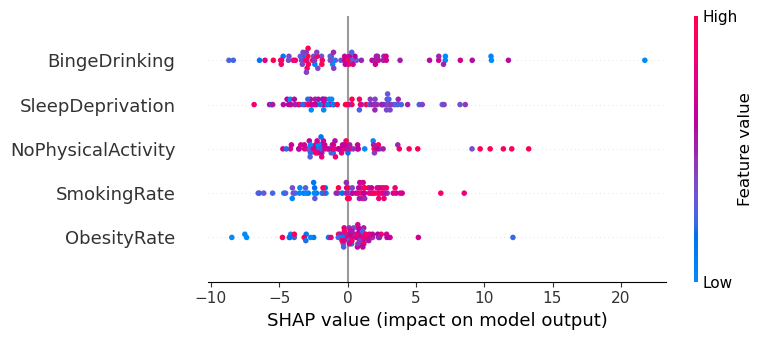

              Feature  Mean |SHAP value|
0       BingeDrinking           3.580634
4    SleepDeprivation           2.869061
2  NoPhysicalActivity           2.610257
1         SmokingRate           2.311447
3         ObesityRate           1.755667


In [6]:
# Train XGBoost model
model = xgb.XGBRegressor(random_state=42, verbosity=0)
model.fit(X, y)

# Explain with SHAP
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Plot summary (feature importance + direction)
shap.summary_plot(shap_values, X)
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Put into a DataFrame for readability
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean |SHAP value|': shap_importance
}).sort_values(by='Mean |SHAP value|', ascending=False)

print(importance_df)

#### Result Analysis

From the results above, BingeDrinking had a surprising effect on cardiovascular search trend predictions, having a feature importance score of 3.58, much higher than the two following features SleepDeprivation and NoPhysicalActivity, with a importance score of 2.86 and 2.61 respectively. Interestingly, ObesityRate has by far the lowest importance score, meaning ObesityRate does not have a great impact on cardiovascular related searches, even though it is considered the leading cause of cardiovascular diseases.

#### Do different clusters of cardiovascular search trends show changes in health behaviors

We will conduct kNN clustering that clusters cardiovascular search trends into 3 major groups and see if there are any differences in health behaviors within these groups.

In [38]:
# Clustering into 3 by Cardiovascular Search Trends
kmeans = KMeans(n_clusters=3, random_state=42)
data['Cluster'] = kmeans.fit_predict(data[target].values.reshape(-1, 1))

cluster_order = data.groupby('Cluster')[target].mean().sort_values().index.tolist()
label_map = {cluster_order[0]: 'Low', cluster_order[1]: 'Med', cluster_order[2]: 'High'}

# Apply the mapping
data['ClusterLabel'] = data['Cluster'].replace(label_map)

# Group by new labels
groups = data.groupby('ClusterLabel')

# Color map using new names
colorMap = {
    'Low': 'green',
    'Med': 'orange',
    'High': 'red'
}

ordered_labels = ['Low', 'Med', 'High']
data['ClusterLabel'] = pd.Categorical(data['ClusterLabel'], 
                                      categories= ordered_labels, ordered=True)



Cluster Low: 21 -- 36
Cluster Med: 37 -- 53
Cluster High: 55 -- 86


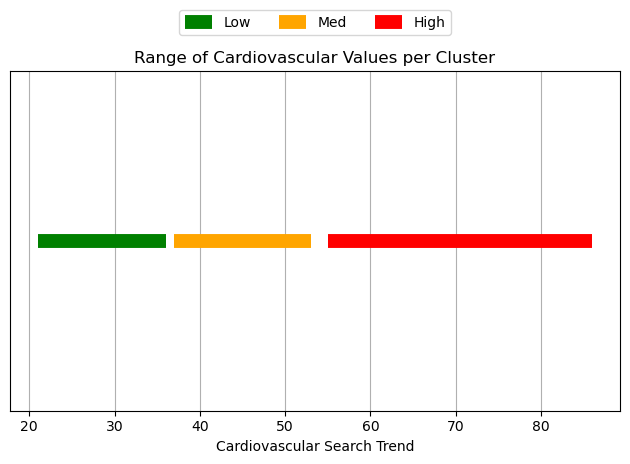

In [39]:
# Code for plotting
for label in ordered_labels:
    group = groups.get_group(label)
    group_max = group[target].max()
    group_min = group[target].min()
    print(f'Cluster {label}: {group_min} -- {group_max}')
    plt.plot(
        [group_min, group_max], [0, 0],
        linewidth=10,
        color=colorMap[label],
        solid_capstyle='butt',
        label=label
    )

plt.yticks([])
plt.xlabel("Cardiovascular Search Trend")
plt.title("Range of Cardiovascular Values per Cluster")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

#### Cluster Analysis

As we can see, our 3 major clusters from cardiovascular search trend formed a low, medium, and high group. Where low is from 21-36, medium is 37-53, and high is from 55-86.

Now, we are going to analyze each cluster's behavior.

In [40]:
groups[features].mean().loc[ordered_labels]

,BingeDrinking,SmokingRate,NoPhysicalActivity,ObesityRate,SleepDeprivation
ClusterLabel,,,,,
Low,17.338095,19.314286,23.628571,29.628571,35.476190
Med,15.593617,21.551064,26.978723,33.840426,37.900000
High,14.391667,22.500000,29.566667,36.000000,39.491667


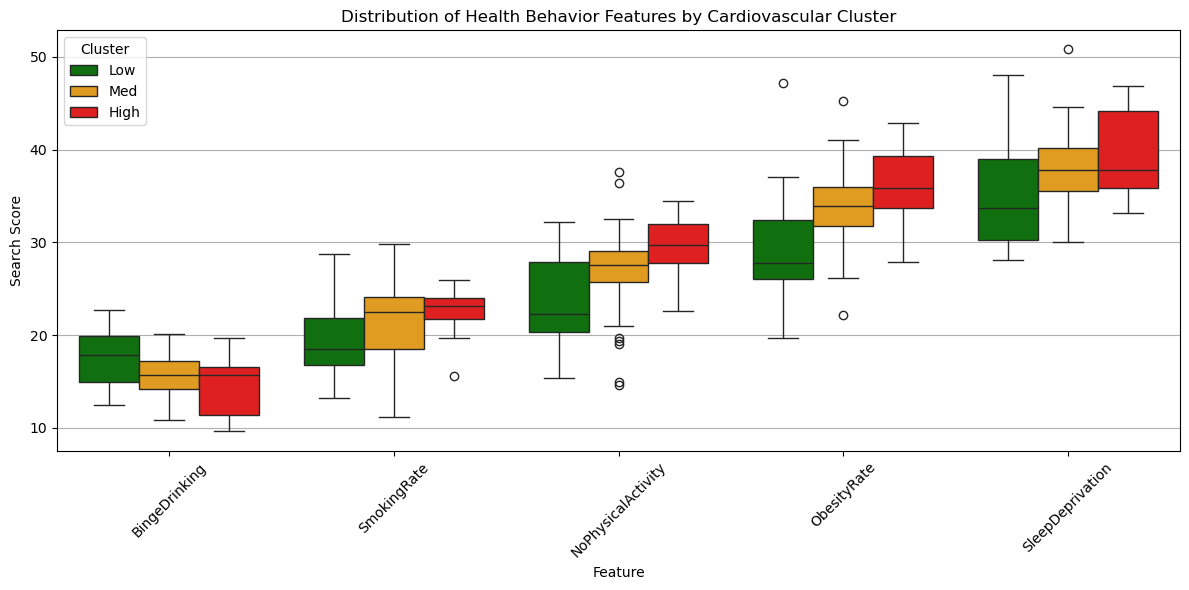

In [41]:
melted = pd.melt(
    data,
    id_vars='ClusterLabel',
    value_vars=features,
    var_name='Feature',
    value_name='Search Score'
)


# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=melted,
    x='Feature',
    y='Search Score',
    hue='ClusterLabel',
    palette=colorMap
)

plt.title('Distribution of Health Behavior Features by Cardiovascular Cluster')
plt.ylabel('Search Score')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.legend(title='Cluster')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Result Analysis

From the above, we can see that our clustered search trends have varying effects on health behavior features, where cities with higher cardiovascular related searches tend to have higher obesity rate, percentage of people with no physical activity, and smoking rate. Cities with different cardiovascular searches don't have a great influence on percentage of sleep deprivatons, which makes sense as the lead cause of sleep deprivation are not cardiovascular diseases. Interestingly, cities with lower binge drinking rates tend to have more cardiovascular related searches, as opposed to every other health behavior features.